In [1]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
import pandas as pd
import numpy as np
import pyarrow as pa
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

In [2]:
# Pegar os dados dos jogos da NBA (2019-20 temporada até hoje)
date_from = '2019-10-22'
date_to = datetime.today().strftime('%Y-%m-%d')

gamefinder = leaguegamefinder.LeagueGameFinder(date_from_nullable=date_from, date_to_nullable=date_to)
games_df = gamefinder.get_data_frames()[0]

# Filtrar jogos da temporada regular 
# ( SEASON_ID:
#   1xxxx - Pré-Temporada
#   2xxxx - Temporada Regular
#   4xxxx - Playoffs
#   5xxxx - Play-In )
df = games_df[games_df['SEASON_ID'].astype(str).str.startswith('2')]

# Salva o dataframe em parquet
df.to_parquet('nba_games_2019_today.parquet', index=False)

In [3]:
df = pd.read_parquet('nba_games_2019_today.parquet')

pd.set_option('display.max_columns', None)
df.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22025,1610612749,MIL,Milwaukee Bucks,0022500541,2026-01-09,MIL @ LAL,W,239,105,38,79,0.481,12,34,0.353,17,22,0.773,12,32,44,23,10,3,16,16,4.0
1,22025,1610612755,PHI,Philadelphia 76ers,0022500533,2026-01-09,PHI @ ORL,W,241,103,39,95,0.411,4,28,0.143,21,24,0.875,21,31,52,20,12,6,12,20,12.0
2,22025,1610612747,LAL,Los Angeles Lakers,0022500541,2026-01-09,LAL vs. MIL,L,239,101,39,91,0.429,15,36,0.417,8,14,0.571,15,30,45,28,9,0,12,20,-4.0
3,22025,1610612753,ORL,Orlando Magic,0022500533,2026-01-09,ORL vs. PHI,L,240,91,36,88,0.409,4,29,0.138,15,18,0.833,11,31,42,21,5,10,18,18,-12.0
4,22025,1610612756,PHX,Phoenix Suns,0022500538,2026-01-09,PHX vs. NYK,W,241,112,38,85,0.447,16,42,0.381,20,23,0.870,9,28,37,23,4,4,9,21,5.0


#### Modelo Random Forest com as features originais pra usar como baseline

In [4]:
# Pré-processamento dos dados pra ML

# Formata a data pra datetime
df_clean = df.copy()
df_clean['GAME_DATE'] = pd.to_datetime(df_clean['GAME_DATE'])

# Cria a variável alvo: vitória ou derrota
df_clean['WIN'] = df_clean['WL'].apply(lambda x: 1 if x == 'W' else 0)

# Codifica variáveis categóricas
le = LabelEncoder()
categorical_features = ['TEAM_ID', 'MATCHUP', 'SEASON_ID', 'GAME_ID']
for feature in categorical_features:
    df_clean[feature] = le.fit_transform(df_clean[feature])

In [5]:
df_clean.describe()

,SEASON_ID,TEAM_ID,GAME_ID,GAME_DATE,MATCHUP,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,WIN
count,15250.000000,15250.000000,15250.000000,15250,15250.000000,15250.000000,15250.000000,15250.000000,15250.000000,15250.000000,15250.000000,15250.000000,15250.000000,15250.000000,15250.000000,15249.000000,15250.000000,15250.000000,15250.000000,15250.000000,15250.000000,15250.000000,15250.00000,15250.000000,15250.000000,15250.000000
mean,2.845377,14.504328,3812.000000,2022-11-24 01:34:25.573770240,870.700459,241.582230,113.165377,41.482033,88.689115,0.468711,12.732131,35.309443,0.359873,17.469180,22.416459,0.779177,10.493574,33.589705,44.083279,25.518033,7.695672,4.858885,13.38000,19.559148,0.001154,0.500000
min,0.000000,0.000000,0.000000,2019-10-22 00:00:00,0.000000,237.000000,67.000000,21.000000,63.000000,0.269000,2.000000,10.000000,0.069000,0.000000,0.000000,0.300000,0.000000,16.000000,20.000000,8.000000,0.000000,0.000000,1.00000,4.000000,-73.000000,0.000000
25%,1.000000,7.000000,1906.000000,2021-04-18 00:00:00,436.000000,240.000000,104.000000,38.000000,84.000000,0.430000,10.000000,30.000000,0.303000,13.000000,17.000000,0.714000,8.000000,30.000000,39.000000,22.000000,6.000000,3.000000,11.00000,17.000000,-10.000000,0.000000
50%,3.000000,15.000000,3812.000000,2022-12-17 00:00:00,871.000000,240.000000,113.000000,41.000000,88.000000,0.468000,12.000000,35.000000,0.358000,17.000000,22.000000,0.786000,10.000000,33.000000,44.000000,25.000000,7.000000,5.000000,13.00000,19.000000,1.000000,0.500000
75%,4.000000,22.000000,5718.000000,2024-04-01 00:00:00,1306.000000,241.000000,122.000000,45.000000,93.000000,0.506000,15.000000,40.000000,0.415000,21.000000,27.000000,0.848000,13.000000,37.000000,48.000000,29.000000,10.000000,6.000000,16.00000,22.000000,10.000000,1.000000
max,6.000000,29.000000,7624.000000,2026-01-09 00:00:00,1739.000000,316.000000,176.000000,65.000000,122.000000,0.689000,29.000000,65.000000,0.680000,45.000000,53.000000,1.000000,29.000000,60.000000,74.000000,50.000000,22.000000,20.000000,31.00000,37.000000,73.000000,1.000000
std,1.851695,8.649772,2201.220055,NaN,502.277777,6.676084,12.623705,5.231186,7.070090,0.054892,3.905054,6.977526,0.083272,5.911173,7.080633,0.100474,3.845480,5.444693,6.645015,5.119578,2.937170,2.469226,3.88453,4.225411,15.124065,0.500016


              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1504
           1       0.71      0.70      0.70      1546

    accuracy                           0.70      3050
   macro avg       0.70      0.70      0.70      3050
weighted avg       0.70      0.70      0.70      3050



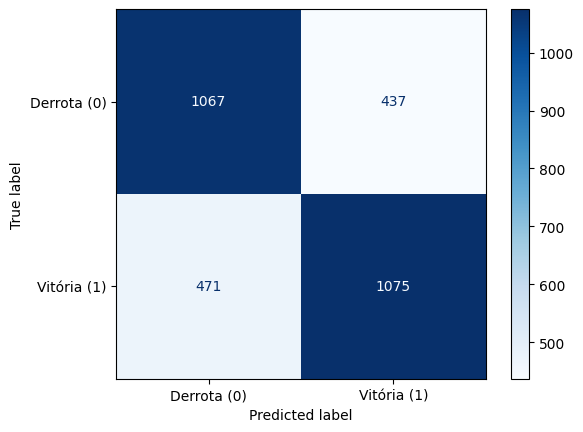

In [6]:
features = ['SEASON_ID', 'TEAM_ID', 'MATCHUP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'TOV']

X = df_clean[features]
y = df_clean['WIN']

# Divide os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treina o modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Faz previsões
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Derrota (0)', 'Vitória (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.show()

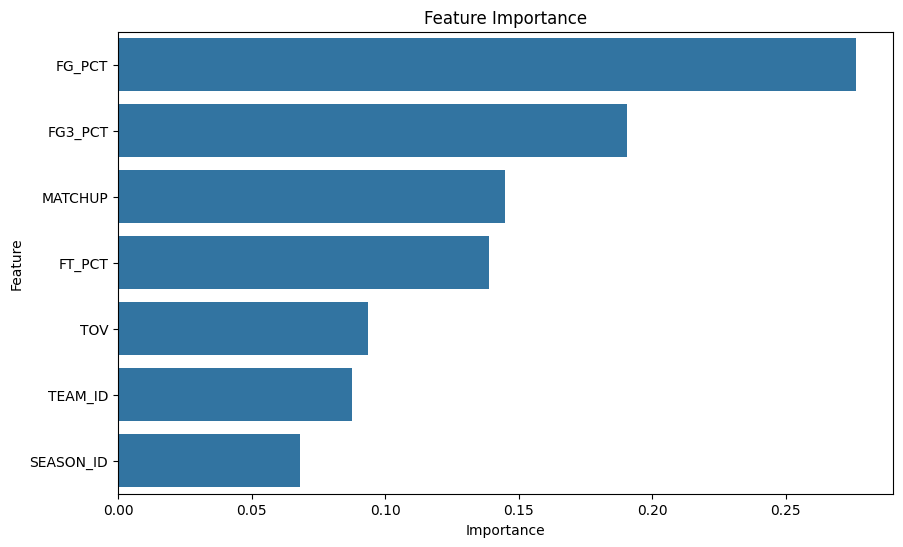

In [7]:
# Feature importance
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

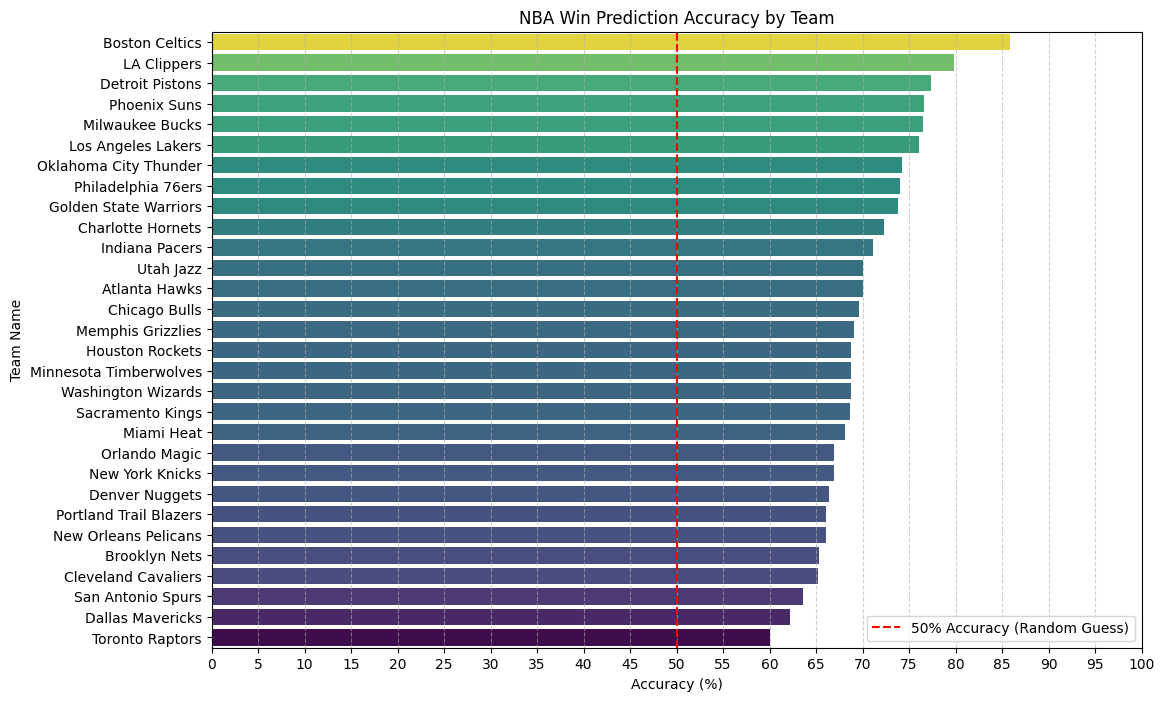

In [10]:
# Calcular acurácia por time

results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

results_df['Team Name'] = df.loc[y_test.index, 'TEAM_NAME']

results_df['Correct Prediction'] = results_df['Actual'] == results_df['Predicted']

team_accuracy = results_df.groupby('Team Name')['Correct Prediction'].mean().reset_index()
team_accuracy.columns = ['Team Name', 'Accuracy']
team_accuracy = team_accuracy.sort_values(by='Accuracy', ascending=False)
team_accuracy['Accuracy_PCT'] = (team_accuracy['Accuracy'] * 100).round(2)

# Visualização
plt.figure(figsize=(12, 8))
sns.barplot(x='Accuracy_PCT', y='Team Name', data=team_accuracy, palette='viridis', hue='Accuracy_PCT', dodge=False, legend=False,)
plt.axvline(x=50, color='red', linestyle='--', label='50% Accuracy (Random Guess)')
plt.xticks(np.arange(0, 101, 5))
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlabel('Accuracy (%)')
plt.ylabel('Team Name')
plt.title('NBA Win Prediction Accuracy by Team')
plt.legend()
plt.show()

#### Modelo Random Forest com Feature Engineering